In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import itertools

# Understanding The Data

In [3]:
# data pre-processing of the family income / comfortability dataset
df = pd.read_excel("fbc_data_2024.xlsx", sheet_name='County', header=1)
ut_df = df[df["State abv."] == 'UT']
cache_county_df = ut_df[ut_df['County'] == 'Cache County']


Costs for Cache County:
	Family Type: 1p0c, Monthly Cost: $3457, Yearly Cost: $41484
	Family Type: 1p1c, Monthly Cost: $5450, Yearly Cost: $65400
	Family Type: 1p2c, Monthly Cost: $7132, Yearly Cost: $85584
	Family Type: 1p3c, Monthly Cost: $8934, Yearly Cost: $107208
	Family Type: 1p4c, Monthly Cost: $9779, Yearly Cost: $117348
	Family Type: 2p0c, Monthly Cost: $4706, Yearly Cost: $56472
	Family Type: 2p1c, Monthly Cost: $6534, Yearly Cost: $78408
	Family Type: 2p2c, Monthly Cost: $7950, Yearly Cost: $95400
	Family Type: 2p3c, Monthly Cost: $9564, Yearly Cost: $114768
	Family Type: 2p4c, Monthly Cost: $10456, Yearly Cost: $125472


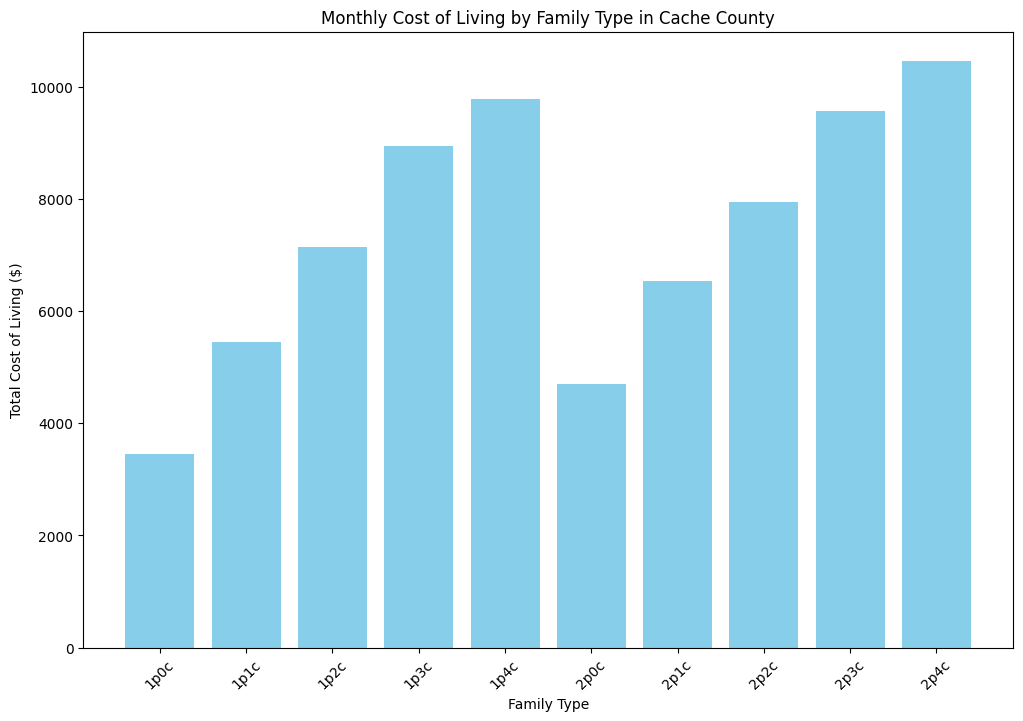

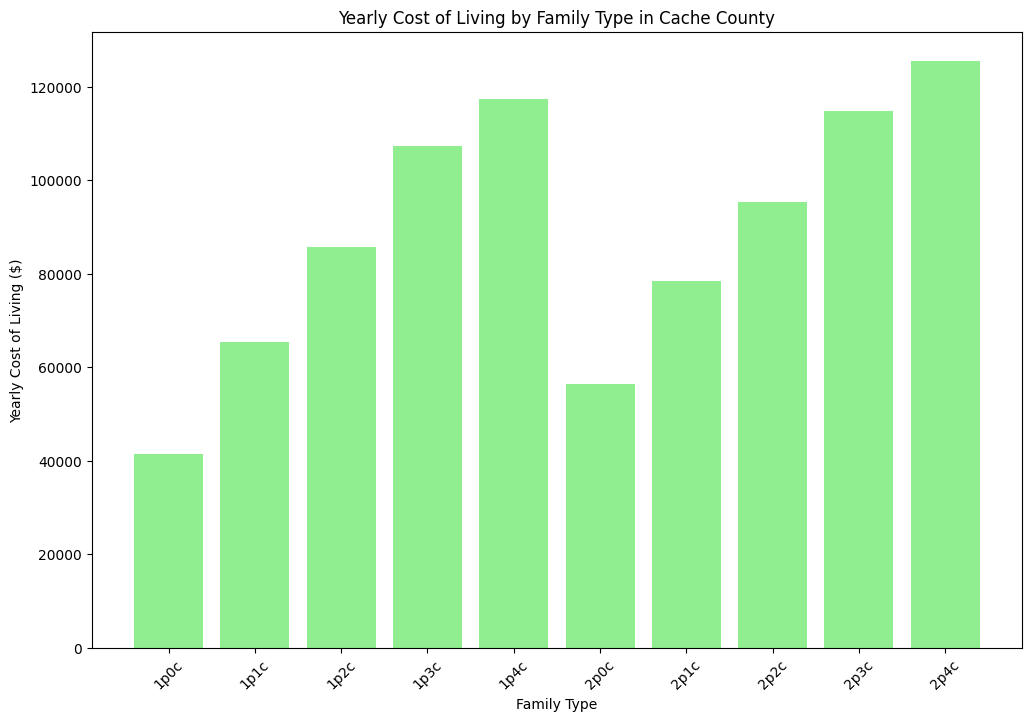


Costs for Salt Lake County:
	Family Type: 1p0c, Monthly Cost: $3961, Yearly Cost: $47532
	Family Type: 1p1c, Monthly Cost: $6262, Yearly Cost: $75144
	Family Type: 1p2c, Monthly Cost: $7882, Yearly Cost: $94584
	Family Type: 1p3c, Monthly Cost: $9964, Yearly Cost: $119568
	Family Type: 1p4c, Monthly Cost: $10863, Yearly Cost: $130356
	Family Type: 2p0c, Monthly Cost: $5375, Yearly Cost: $64500
	Family Type: 2p1c, Monthly Cost: $7191, Yearly Cost: $86292
	Family Type: 2p2c, Monthly Cost: $8573, Yearly Cost: $102876
	Family Type: 2p3c, Monthly Cost: $10587, Yearly Cost: $127044
	Family Type: 2p4c, Monthly Cost: $11465, Yearly Cost: $137580


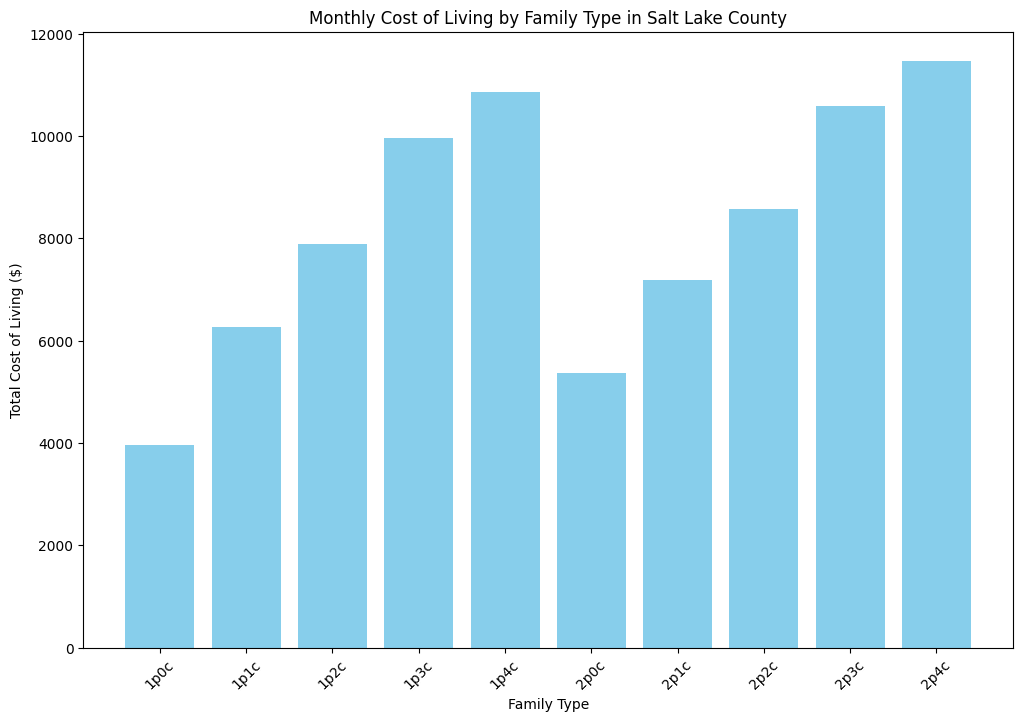

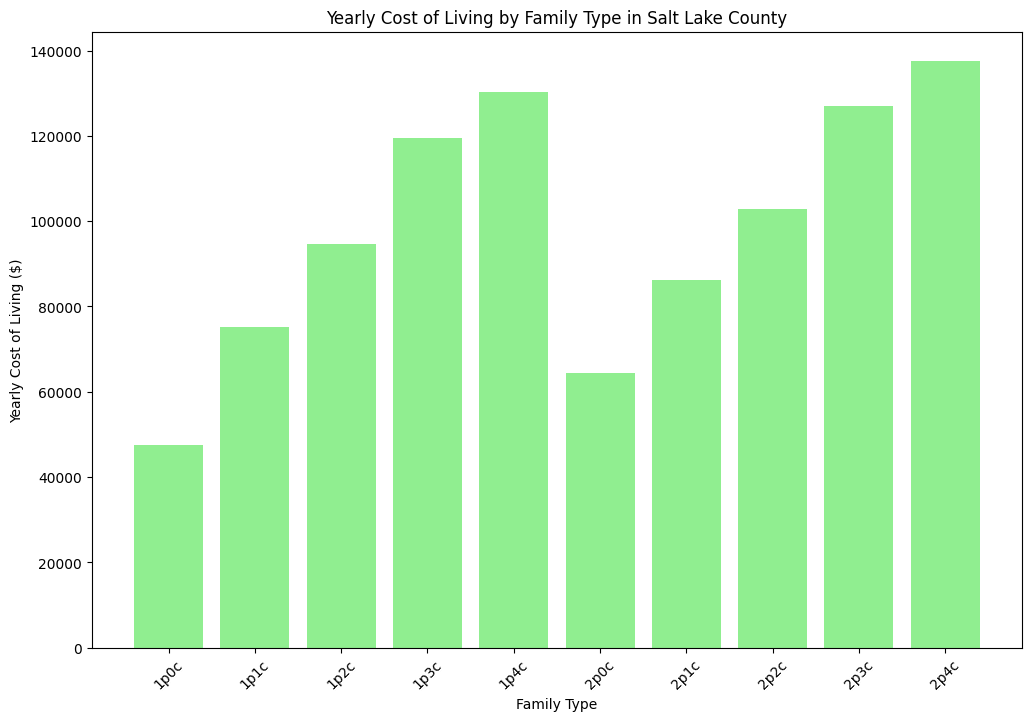

In [4]:
def CostOfLivingPerCounty(county_name, plot=False):
    specific_county_df = ut_df[ut_df['County'] == county_name]
    family_types = specific_county_df['Family']
    
    monthly_total_costs = specific_county_df['Total']
    yearly_total_costs = specific_county_df['Total.1']

    print(f"\nCosts for {county_name}:")
    for family, monthly_cost, yearly_cost in zip(family_types, monthly_total_costs, yearly_total_costs):
        print(f"\tFamily Type: {family}, Monthly Cost: ${monthly_cost}, Yearly Cost: ${yearly_cost}")

    if (plot):
        # Monthly costs
        plt.figure(figsize=(12, 8))
        plt.bar(family_types, monthly_total_costs, color='skyblue')
        plt.xlabel('Family Type')
        plt.ylabel('Total Cost of Living ($)')
        plt.title(f'Monthly Cost of Living by Family Type in {county_name}')
        plt.xticks(rotation=45)
        plt.show()

        # Yearly costs
        plt.figure(figsize=(12, 8))
        plt.bar(family_types, yearly_total_costs, color='lightgreen')
        plt.xlabel('Family Type')
        plt.ylabel('Yearly Cost of Living ($)')
        plt.title(f'Yearly Cost of Living by Family Type in {county_name}')
        plt.xticks(rotation=45)
        plt.show()

CostOfLivingPerCounty("Cache County", plot=True)
CostOfLivingPerCounty("Salt Lake County", plot=True)

In [5]:
def TopCountiesByCost(num, descending=True):
    average_costs = {}
    
    for county in ut_df['County'].unique():
        county_data = ut_df[ut_df['County'] == county]
        average_monthly_cost = county_data['Total'].mean()
        average_costs[county] = average_monthly_cost
        
    top_counties = sorted(average_costs, key=average_costs.get, reverse=descending)[:num]

    adj = 'most' if descending else 'least'
    print(f"\nTop {num} {adj} expensive counties by monthly cost:")
    for county in top_counties:
        print(f"\t{county}: ${average_costs[county]:.2f}")

TopCountiesByCost(5)
TopCountiesByCost(5, descending=False)


Top 5 most expensive counties by monthly cost:
	Summit County: $9009.40
	Morgan County: $8739.90
	Salt Lake County: $8212.30
	Washington County: $8098.80
	Wasatch County: $8098.70

Top 5 least expensive counties by monthly cost:
	Carbon County: $7085.10
	Sevier County: $7207.20
	Beaver County: $7218.90
	Emery County: $7225.80
	Duchesne County: $7254.60


/var/folders/rq/spfrzsdj4h972cbb18qh4jj80000gn/T/ipykernel_91078/2301503150.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/rq/spfrzsdj4h972cbb18qh4jj80000gn/T/ipykernel_91078/2301503150.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


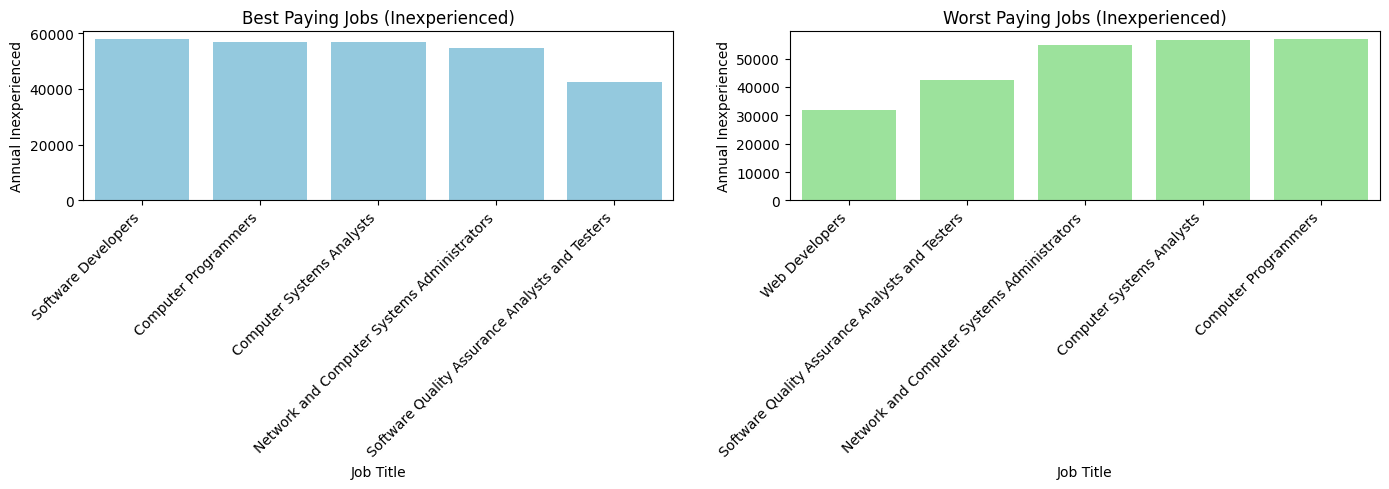

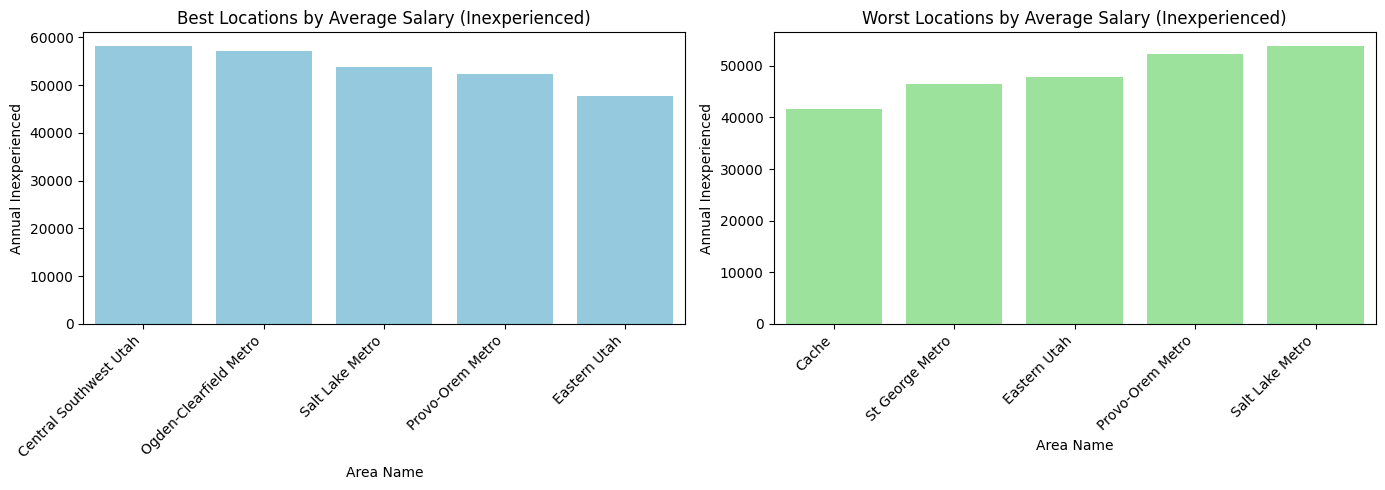

/var/folders/rq/spfrzsdj4h972cbb18qh4jj80000gn/T/ipykernel_91078/2301503150.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/rq/spfrzsdj4h972cbb18qh4jj80000gn/T/ipykernel_91078/2301503150.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


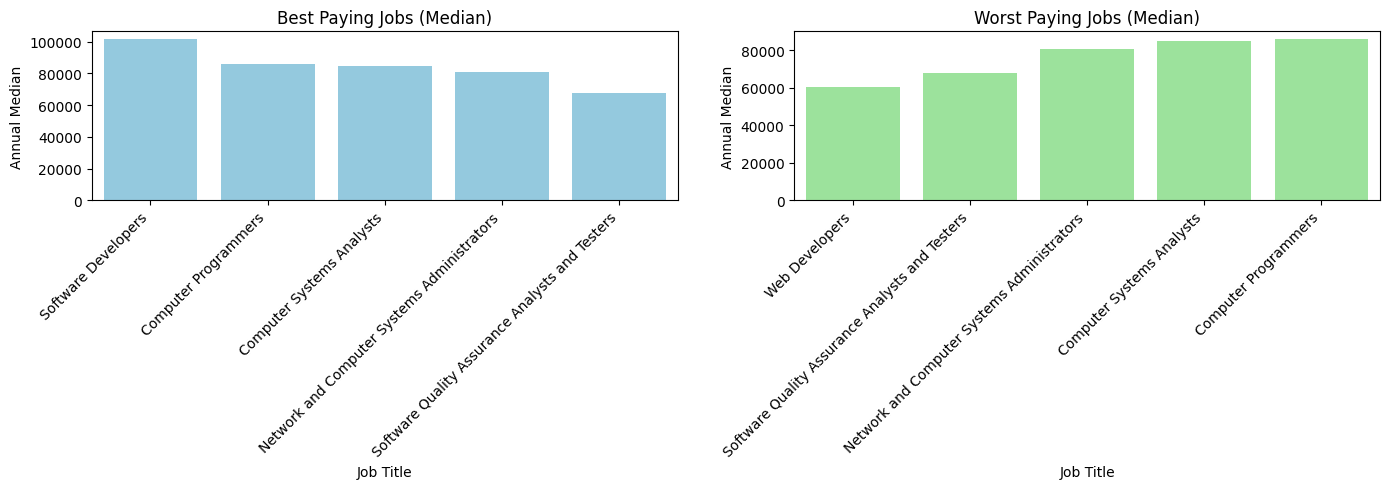

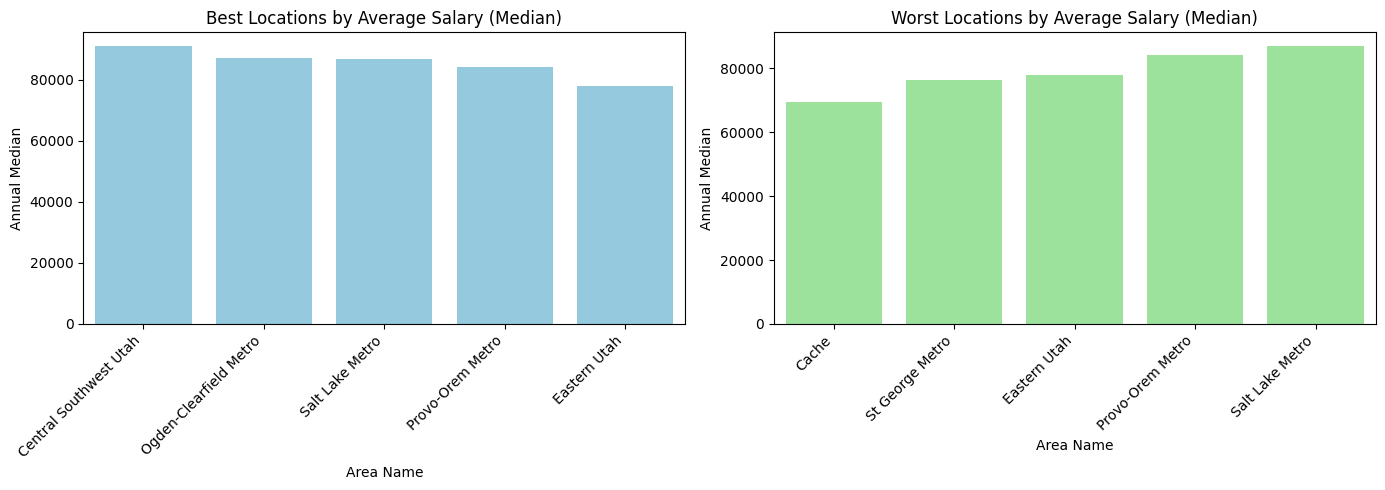

In [6]:
# pre-processing wages dataset
df = pd.read_excel("wages.xlsx")
wage_df = df[~df['Area Name'].isin(['United States', 'Statewide'])]

def wagesAnalysis(wage_data, inexperienced=True):
    adj = 'Inexperienced' if inexperienced else 'Median'
    
    # analysis of average salary by job title
    average_salary_by_job = wage_data.groupby('Job Title')[f'Annual {adj}'].mean().reset_index()
    best_paying_jobs = average_salary_by_job.sort_values(by=f'Annual {adj}', ascending=False).head()
    worst_paying_jobs = average_salary_by_job.sort_values(by=f'Annual {adj}', ascending=True).head()
    
    # plotting best and worst paying jobs
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    sns.barplot(x='Job Title', y=f'Annual {adj}', data=best_paying_jobs, ax=axes[0], color='skyblue')
    axes[0].set_title(f'Best Paying Jobs ({adj})')
    sns.barplot(x='Job Title', y=f'Annual {adj}', data=worst_paying_jobs, ax=axes[1], color='lightgreen')
    axes[1].set_title(f'Worst Paying Jobs ({adj})')
    for ax in axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()

    # analysis of average salary by area
    average_salary_by_area = wage_data.groupby('Area Name')[f'Annual {adj}'].mean().reset_index()
    best_locations = average_salary_by_area.sort_values(by=f'Annual {adj}', ascending=False).head()
    worst_locations = average_salary_by_area.sort_values(by=f'Annual {adj}', ascending=True).head()
    
    # plotting best and worst locations for salaries vertically
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    sns.barplot(x='Area Name', y=f'Annual {adj}', data=best_locations, ax=axes[0], color='skyblue')
    axes[0].set_title(f'Best Locations by Average Salary ({adj})')
    sns.barplot(x='Area Name', y=f'Annual {adj}', data=worst_locations, ax=axes[1], color='lightgreen')
    axes[1].set_title(f'Worst Locations by Average Salary ({adj})')
    for ax in axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

wagesAnalysis(wage_df, inexperienced=True)
wagesAnalysis(wage_df, inexperienced=False)

# Analysis 1: Salary vs Cost of Living

In [7]:
# pre-processing. get the combined dataset
df = pd.read_excel("wages.xlsx")
wage_df = df[~df['Area Name'].isin(['United States', 'Statewide']).copy()]
wage_df.rename(columns={'Area Name': 'County'}, inplace=True)

# apply the mapping to wage_df to create a new 'Mapped County' column
wage_df['Mapped County'] = wage_df['County'].map({
    'Cache': 'Cache County',
    'Central Southwest Utah': 'Beaver County',
    'Eastern Utah': 'Carbon County',
    'Ogden-Clearfield Metro': 'Weber County',
    'Provo-Orem Metro': 'Utah County',
    'Salt Lake Metro': 'Salt Lake County',
    'St George Metro': 'Washington County'
})

combined_df = pd.merge(wage_df, ut_df, left_on='Mapped County', right_on='County')

# - An Affordability Index > 1 means income is greater than the cost of living (more affordable).
# - An Affordability Index < 1 means income is less than the cost of living (less affordable).
combined_df['Affordability Index'] = combined_df['Annual Median'] / combined_df['Total.1']

/var/folders/rq/spfrzsdj4h972cbb18qh4jj80000gn/T/ipykernel_91078/7243343.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wage_df.rename(columns={'Area Name': 'County'}, inplace=True)
/var/folders/rq/spfrzsdj4h972cbb18qh4jj80000gn/T/ipykernel_91078/7243343.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wage_df['Mapped County'] = wage_df['County'].map({


In [8]:
def affordabilityAnalysis(num):
    # Exclude rows where 'Annual Median' or 'Total.1' is NaN
    df = combined_df.dropna(subset=['Annual Median', 'Total.1'])

    # Calculate the affordability index
    df['Affordability Index'] = df['Annual Median'] / df['Total.1']
    sorted_df = df.sort_values(by='Affordability Index', ascending=False)
    
    # Get the top most affordable
    most_affordable = sorted_df.head(num)
    
    # Get the top least affordable
    least_affordable = sorted_df.tail(num)

    print(f"Top {num} Most Affordable:")
    print(most_affordable[['Job Title', 'Mapped County', 'Annual Median', 'Total.1', 'Affordability Index']])
    print(f"\nTop {num} Least Affordable:")
    print(least_affordable[['Job Title', 'Mapped County', 'Annual Median', 'Total.1', 'Affordability Index']])
        
affordabilityAnalysis(8)

Top 8 Most Affordable:
                     Job Title      Mapped County  Annual Median  Total.1  \
120        Software Developers      Carbon County       104020.0    40152   
60         Software Developers      Beaver County        98720.0    40728   
180        Software Developers       Weber County       106680.0    45324   
240        Software Developers        Utah County       111240.0    47640   
190  Computer Systems Analysts       Weber County       103370.0    45324   
300        Software Developers   Salt Lake County       106880.0    47532   
260       Computer Programmers        Utah County       104110.0    47640   
360        Software Developers  Washington County        97390.0    47076   

     Affordability Index  
120             2.590656  
60              2.423885  
180             2.353720  
240             2.335013  
190             2.280690  
300             2.248590  
260             2.185348  
360             2.068782  

Top 8 Least Affordable:
               

/var/folders/rq/spfrzsdj4h972cbb18qh4jj80000gn/T/ipykernel_91078/1578103674.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Affordability Index'] = df['Annual Median'] / df['Total.1']


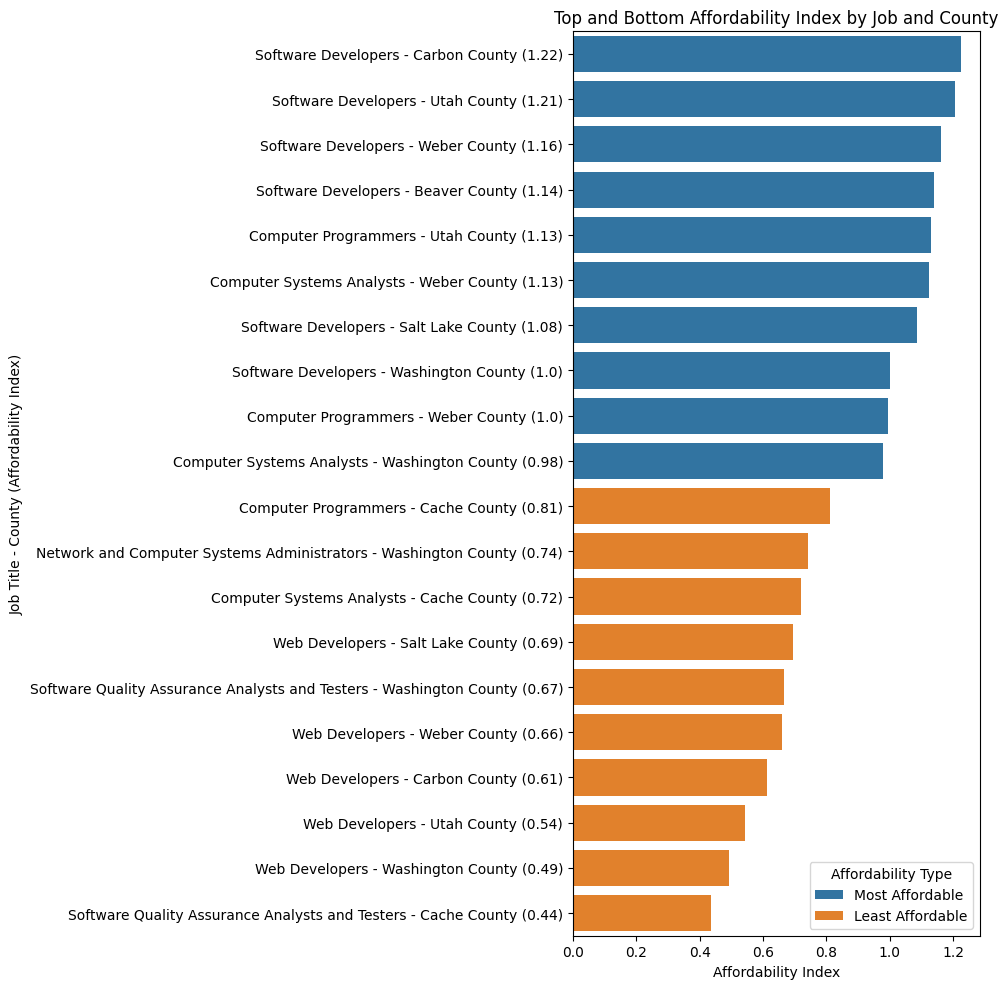

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plotAffordability(combined_df, num=5):
    # Exclude rows where 'Annual Median' or 'Total.1' is NaN
    df = combined_df.dropna(subset=['Annual Median', 'Total.1'])

    # Group by 'Job Title' and 'Mapped County' and calculate the mean 'Annual Median' and 'Total.1'
    df_grouped = df.groupby(['Job Title', 'Mapped County']).agg({
        'Annual Median': 'mean',
        'Total.1': 'mean'
    }).reset_index()

    # Calculate the affordability index
    df_grouped['Affordability Index'] = df_grouped['Annual Median'] / df_grouped['Total.1']
    sorted_df = df_grouped.sort_values(by='Affordability Index', ascending=False)
    
    most_affordable = sorted_df.head(num)
    least_affordable = sorted_df.tail(num)

    # Combine for plotting
    plot_df = pd.concat([most_affordable, least_affordable])
    plot_df['Type'] = ['Most Affordable'] * num + ['Least Affordable'] * num
    plot_df['Label'] = plot_df['Job Title'] + " - " + plot_df['Mapped County'] + \
                       " (" + plot_df['Affordability Index'].round(2).astype(str) + ")"
    
    # Create a bar plot
    plt.figure(figsize=(10, 10))
    sns.barplot(x='Affordability Index', y='Label', hue='Type', data=plot_df, dodge=False)
    plt.title('Top and Bottom Affordability Index by Job and County')
    plt.xlabel('Affordability Index')
    plt.ylabel('Job Title - County (Affordability Index)')
    plt.legend(title='Affordability Type', loc='lower right')
    plt.tight_layout()
    plt.show()

# Note: Replace 'combined_df' with the actual DataFrame object that contains your data.
plotAffordability(combined_df, 10)


# Analysis 2: Comparing affordability index between job types

- Software Developers vs. Web Developers (P-Value ~ 7.86e-11): This indicates a highly significant difference in affordability, with Software Developers likely being more affordable compared to Web Developers, given the positive T-Stat (7.095041).

- Software Developers vs. Software QA Analysts and Testers (P-Value ~ 1.40e-07): Another highly significant difference, suggesting that Software Developers tend to have a higher affordability index than QA Analysts and Testers.

- Computer Programmers vs. Web Developers (P-Value ~ 1.02e-05): This shows a significant difference in affordability, with Programmers potentially having a higher affordability index than Web Developers, indicated by the positive T-stat (4.611752).

- Web Developers vs. Network and Computer Systems Administrators (P-Value ~ 5.55e-05): A significant result, but the negative T-Stat (-4.170889) suggests that Web Developers have a lower affordability index compared to Network and Computer Systems Administrators.

- Software QA Analysts and Testers vs. Web Developers (P-Value ~ 0.263): There is no evidence of a statistically significant difference in affordability between these two job titles.

In [10]:
# The affordabilityTTests function aggregates data for each unique job title across all counties, effectively averaging out any variations in the 'Affordability Index' that might occur due to different county-specific factors.
# This approach treats all entries with the same job title as a single group for statistical analysis, regardless of variations that might exist between different counties.
def affordabilityTTests(df):
    # Get all unique job titles
    job_titles = df['Job Title'].unique()
    t_test_results = []

    # Perform T-tests for all unique combinations of job titles
    for job1, job2 in itertools.combinations(job_titles, 2):
        job1_df = df[df['Job Title'] == job1]
        job2_df = df[df['Job Title'] == job2]
        
        t_stat, p_val = stats.ttest_ind(job1_df['Affordability Index'], job2_df['Affordability Index'], nan_policy='omit')
        
        # Store the results in the list
        t_test_results.append({
            'Job Title 1': job1,
            'Job Title 2': job2,
            'T-Stat': t_stat,
            'P-Value': p_val
        })

    # Convert the list of results to a DataFrame for easy viewing
    results_df = pd.DataFrame(t_test_results)
    
    # Sort by P-Value to see the most significant results at the top
    results_df = results_df.sort_values(by='P-Value').reset_index(drop=True)
    print(results_df)

affordabilityTTests(combined_df)

                                        Job Title 1  \
0                               Software Developers   
1                               Software Developers   
2                              Computer Programmers   
3                                    Web Developers   
4                         Computer Systems Analysts   
5                               Software Developers   
6                              Computer Programmers   
7                               Software Developers   
8   Software Quality Assurance Analysts and Testers   
9                         Computer Systems Analysts   
10                              Software Developers   
11  Software Quality Assurance Analysts and Testers   
12                             Computer Programmers   
13                        Computer Systems Analysts   
14                        Computer Systems Analysts   

                                        Job Title 2    T-Stat       P-Value  
0                                    Web 